In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [257]:
epsilon = 0.000016
theta = 0.000032

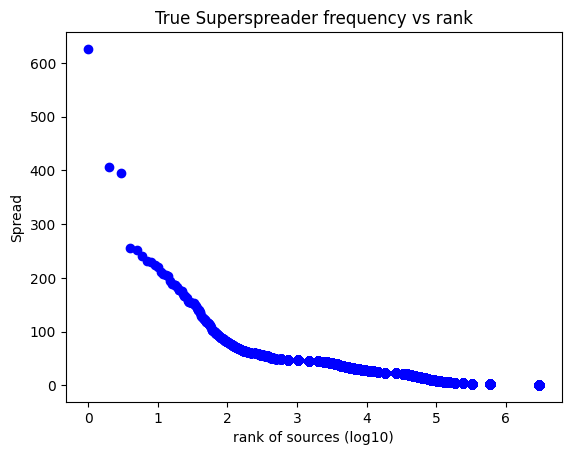

In [258]:
superspreader_true = pd.read_csv("../superspreaders_true.csv")

superspreader_true["rank"] = (
    superspreader_true["freq"].rank(ascending=False)
)

superspreader_true["log_rank"] = np.log10(superspreader_true["rank"])

plt.scatter(
    superspreader_true["log_rank"],
    superspreader_true["freq"],
    color="blue",
)
plt.xlabel("rank of sources (log10)")
plt.ylabel("Spread")
plt.title("True Superspreader frequency vs rank")
plt.show()

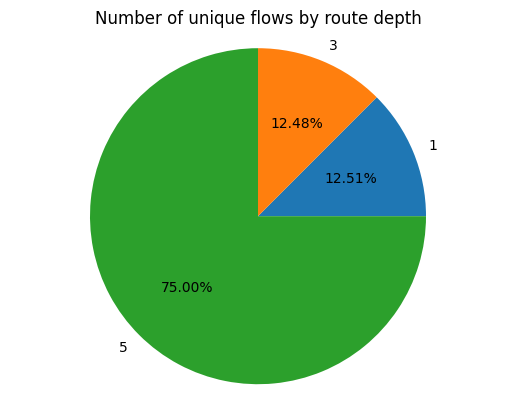

Number of unique flows by route depth
   route_depth  unique_flow
0            1      1053157
1            3      1050639
2            5      6312343
Total number of unique flows: 8416139


In [259]:
# sim_data['src', 'dst', 'freq', 'route_depth']
sim_data = pd.read_csv("../logs/sim.csv")
sim_data.rename(columns={"length": "route_depth"}, inplace=True)
number_of_unique_flow_by_route = (
    sim_data.groupby("route_depth").size().reset_index(name="unique_flow")
)

# pie chart, show unique flows for each route depth
fig, ax = plt.subplots()
ax.pie(
    number_of_unique_flow_by_route["unique_flow"],
    labels=number_of_unique_flow_by_route["route_depth"],
    autopct="%1.2f%%",
)
ax.axis("equal")
plt.title("Number of unique flows by route depth")
plt.show()

print("Number of unique flows by route depth")
print(number_of_unique_flow_by_route)
print(f"Total number of unique flows: {number_of_unique_flow_by_route['unique_flow'].sum()}")

U = number_of_unique_flow_by_route["unique_flow"].sum()


In [260]:
# actual_layer, measure_layer, switch_idx, k, sampled_hash, hash, src
samples = pd.read_csv("../superspreaders.csv")
heaps = samples[['actual_layer', 'measure_layer', 'switch_idx', 'k', 'sampled_hash']].drop_duplicates()

layer2depth2switches2samples = {}

for i, row in samples.iterrows():
    layer = row['actual_layer']
    depth = row['measure_layer']
    switch = row['switch_idx']
    if layer not in layer2depth2switches2samples:
        layer2depth2switches2samples[layer] = {}
    if depth not in layer2depth2switches2samples[layer]:
        layer2depth2switches2samples[layer][depth] = {}
    if switch not in layer2depth2switches2samples[layer][depth]:
        layer2depth2switches2samples[layer][depth][switch] = {
            'samples': [],
            'count': row['sampled_hash'],
            'k': row['k']
        }
    layer2depth2switches2samples[layer][depth][switch]['samples'].append((row['hash'], row['src']))


In [261]:
# Modified k mean merge

layer2depth2samples = {}

for layer in layer2depth2switches2samples:
    for depth in layer2depth2switches2samples[layer]:
        T = np.Inf
        merged = []
        seen = set()

        for switch in layer2depth2switches2samples[layer][depth]:
            samples = layer2depth2switches2samples[layer][depth][switch]['samples']
            k = layer2depth2switches2samples[layer][depth][switch]['k']
            count = layer2depth2switches2samples[layer][depth][switch]['count']
            layer2depth2switches2samples[layer][depth][switch]['samples'] = sorted(samples, key=lambda x: x[0])

            if layer2depth2switches2samples[layer][depth][switch]['samples'][-1][0] < T:
                T = layer2depth2switches2samples[layer][depth][switch]['samples'][-1][0]
            
            if count < k:
                print("WARNING: EDGE CASES WHEN SAMPLES ARE NOT FILLED ARE NOT HANDLED USING THIS MERGE STRATEGY")
                exit(1)

        for switch in layer2depth2switches2samples[layer][depth]:
            samples = layer2depth2switches2samples[layer][depth][switch]['samples']
            k = layer2depth2switches2samples[layer][depth][switch]['k']
            count = layer2depth2switches2samples[layer][depth][switch]['count']

            for s in samples:
                if s[0] in seen:
                    pass
                else:
                    if s[0] <= T:
                        merged.append(s)
                        seen.add(s[0])
                    else:
                        break
        
        print(f"Layer {layer}, depth {depth}, T {T}, k {k}, merged {len(merged)}")
        assert len(merged) >= k

        if layer not in layer2depth2samples:
            layer2depth2samples[layer] = {}

        layer2depth2samples[layer][depth] = {
            'samples': merged,
            'T': T,
            'k': k
        }

Layer 0, depth 5, T 368933621, k 131072, merged 522131
Layer 1, depth 5, T 377687415, k 65536, merged 517715
Layer 2, depth 1, T 1086410797, k 32768, merged 251228
Layer 2, depth 3, T 1088317069, k 32768, merged 250237


In [262]:
depth2cardinatlity_approx = {}
for layer in layer2depth2samples:
    for depth in layer2depth2samples[layer]:
        if depth not in depth2cardinatlity_approx:
            depth2cardinatlity_approx[depth] = []
        
        approx = (len(layer2depth2samples[layer][depth]['samples'])-1)/(layer2depth2samples[layer][depth]['samples'][-1][0]/((2**32)-1))
        depth2cardinatlity_approx[depth].append((approx, len(layer2depth2samples[layer][depth]['samples'])))

for depth in depth2cardinatlity_approx:
    total_weight = 0

    for approx, size in depth2cardinatlity_approx[depth]:
        total_weight += size
    
    depth2cardinatlity_approx[depth] = sum([approx*size/total_weight for approx, size in depth2cardinatlity_approx[depth]])

print(depth2cardinatlity_approx)

print(number_of_unique_flow_by_route)

{5: 5983314.112883235, 1: 993211.8342710509, 3: 987567.5744867065}
   route_depth  unique_flow
0            1      1053157
1            3      1050639
2            5      6312343


In [263]:
depth2freqandsize = {}

for layer in layer2depth2samples:
    for depth in layer2depth2samples[layer]:
        samples = layer2depth2samples[layer][depth]['samples']

        freq = {}
        size = len(samples)

        print(f"Layer {layer}, depth {depth}, size {size}")

        for s in samples:
            if s[1] not in freq:
                freq[s[1]] = 0
            freq[s[1]] += 1

        if depth not in depth2freqandsize:
            depth2freqandsize[depth] = []

        depth2freqandsize[depth].append({
            'freq': freq,
            'size': size
        })


# for depth in depth2freqandsize:
#     for i in range(len(depth2freqandsize[depth])):
#         size = depth2freqandsize[depth][i]['size']
#         scale = depth2cardinatlity_approx[depth] / size
#         print(f"depth {depth}, size {size}, scale {scale}")

#         for src in depth2freqandsize[depth][i]['freq']:
#             depth2freqandsize[depth][i]['freq'][src] = depth2freqandsize[depth][i]['freq'][src] * scale

depth2freq = {}

for depth in depth2freqandsize:
    freq = {}
    count = {}
    total_weight = 0
    sampling_probabilities = []

    for i in range(len(depth2freqandsize[depth])):
        pj = depth2freqandsize[depth][i]['size'] / depth2cardinatlity_approx[depth]
        sampling_probabilities.append(pj)
        print(f"depth {depth}, size {depth2freqandsize[depth][i]['size']}, pj {pj}")

    for i in range(len(depth2freqandsize[depth])):
        freq_size = depth2freqandsize[depth][i]
        for src in freq_size['freq']:
            if src not in freq:
                freq[src] = 0
                count[src] = 0
            f = freq_size['freq'][src]
            count[src] += 1
            freq[src] = freq[src] + f / sampling_probabilities[i]

    for src in freq:
        freq[src] = freq[src] / count[src]
    depth2freq[depth] = freq

depth2freq


Layer 0, depth 5, size 522131
Layer 1, depth 5, size 517715
Layer 2, depth 1, size 251228
Layer 2, depth 3, size 250237
depth 5, size 522131, pj 0.08726451430583441
depth 5, size 517715, pj 0.08652646179568932
depth 1, size 251228, pj 0.2529450328029811
depth 3, size 250237, pj 0.2533872177102028


{5: {'0.0.148.76:0': 11.45941174318942,
  '43.131.172.79:0': 11.45941174318942,
  '170.234.190.182:0': 11.45941174318942,
  '162.223.107.192:0': 22.91882348637884,
  '193.63.73.171:0': 11.45941174318942,
  '46.6.16.212:0': 11.45941174318942,
  '3.159.249.120:0': 11.45941174318942,
  '188.73.76.238:0': 11.45941174318942,
  '53.249.95.62:0': 11.45941174318942,
  '158.203.112.42:0': 22.967696671681495,
  '80.202.99.218:0': 11.45941174318942,
  '163.195.158.51:0': 11.45941174318942,
  '96.56.207.36:0': 11.508284928492072,
  '90.43.9.244:0': 11.45941174318942,
  '102.56.128.246:0': 11.45941174318942,
  '246.189.15.128:0': 11.45941174318942,
  '98.182.79.205:0': 11.45941174318942,
  '61.83.128.196:0': 11.45941174318942,
  '68.123.121.207:0': 51.762845585563,
  '112.197.166.220:0': 11.45941174318942,
  '233.125.58.218:0': 11.45941174318942,
  '192.47.57.212:0': 11.45941174318942,
  '191.157.193.213:0': 23.016569856984145,
  '179.167.218.73:0': 23.016569856984145,
  '174.81.121.113:0': 22.9188

In [264]:
# depth2freqandsize[1][0]['freq']["190.115.47.149:0"]

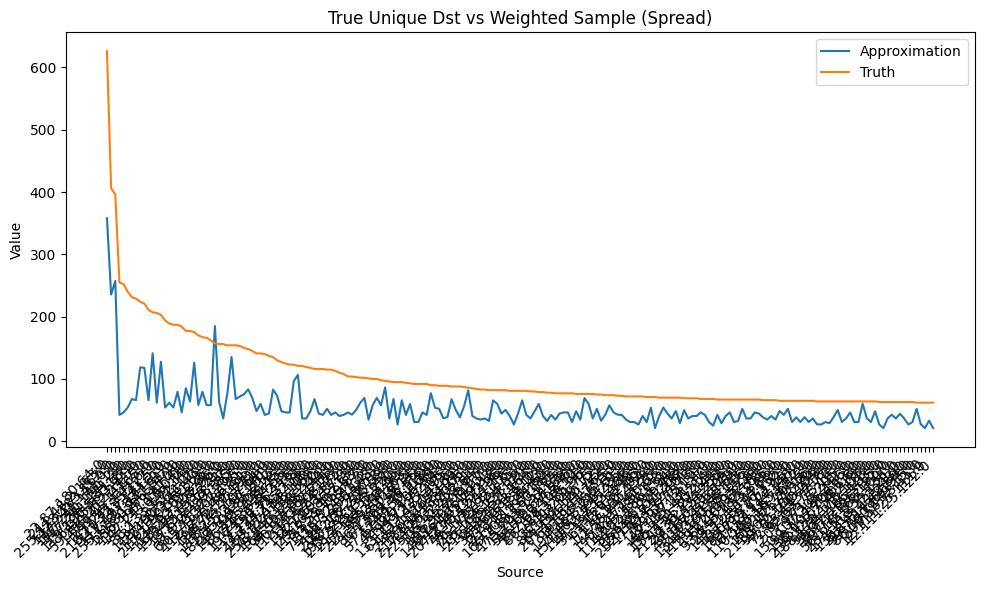

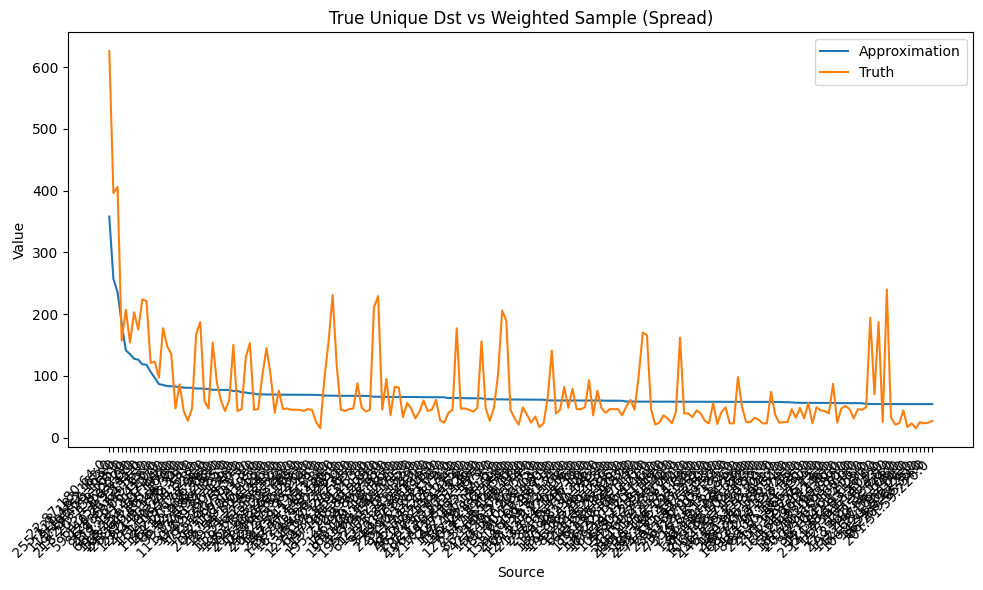

In [265]:
spread = {}

for depth in depth2freq:
    for src in depth2freq[depth]:
        if src not in spread:
            spread[src] = 0
        spread[src] += depth2freq[depth][src]

spread_df = pd.DataFrame.from_dict(spread, orient='index', columns=['freq'])
spread_df.sort_values(by='freq', ascending=False, inplace=True)
spread_df['rank'] = spread_df['freq'].rank(ascending=False)
spread_df['src'] = spread_df.index

# merge with true superspreader

spread_with_true = superspreader_true.merge(spread_df, left_on='src', right_on='src', how='left')

spread_with_true['freq_y'] = spread_with_true['freq_y'].fillna(0)

spread_with_true['rank_y'] = spread_with_true['freq_y'].rank(ascending=False)

spread_with_true['log_rank_y'] = np.log10(spread_with_true['rank_y'])

spread_with_true.rename(columns={'freq_x': 'true_freq'}, inplace=True)
spread_with_true.rename(columns={'freq_y': 'approx_freq'}, inplace=True)

spread_with_true.sort_values(by='true_freq', ascending=False, inplace=True)

def plot(pltdf, title_tag=""):
    plt.figure(figsize=(10, 6))
    plt.plot(pltdf['src'], pltdf['approx_freq'], label='Approximation') #, marker='o')
    plt.plot(pltdf['src'], pltdf['true_freq'], label='Truth') #, marker='o')
    # plt.plot(pltdf['src'], pltdf['max_scaling_factor'], label='Scaling', marker='s')
    plt.xlabel('Source')
    plt.ylabel('Value')
    plt.title(f'True Unique Dst vs Weighted Sample ({title_tag})')
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot(spread_with_true.head(200), "Spread")

spread_with_true.sort_values(by='approx_freq', ascending=False, inplace=True)

plot(spread_with_true.head(200), "Spread")



In [266]:
threshold = int(theta * U)

base = int(U*(theta - epsilon/2))

error = int(U*(theta - epsilon))

print(f"Threshold: {threshold}, Base: {base}, Error: {error}")

true = spread_with_true[superspreader_true['freq'] >= threshold]
acceptable = spread_with_true[superspreader_true['freq'] >= error]
predicted = spread_with_true[spread_with_true['approx_freq'] >= base]

print(len(true), len(acceptable), len(predicted))

Threshold: 269, Base: 201, Error: 134


/var/folders/rv/xz6mnljn2f18wss50lyl5w040000gn/T/ipykernel_12292/1777318054.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  true = spread_with_true[superspreader_true['freq'] >= threshold]


3 41 3


/var/folders/rv/xz6mnljn2f18wss50lyl5w040000gn/T/ipykernel_12292/1777318054.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  acceptable = spread_with_true[superspreader_true['freq'] >= error]


In [267]:

tp, fp, fn = 0, 0, 0

for row in predicted.itertuples():
    if row.src in acceptable['src'].values:
        tp += 1
    else:
        fp += 1
        print(f"False Positive {row}")

for row in true.itertuples():
    if row.src not in predicted['src'].values:
        fn += 1
        print(f"False Negative {row}")

print(f"True Positives {tp} / {len(predicted)}")
print(f"False Positives {fp} / {len(predicted)}")
print(f"False Negatives {fn} / {len(true)}")
    
precision = tp / (tp + fp)
recall = tp / (tp + fn)

f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision {precision}")
print(f"Recall {recall}")
print(f"F1 Score {f1}")

True Positives 3 / 3
False Positives 0 / 3
False Negatives 0 / 3
Precision 1.0
Recall 1.0
F1 Score 1.0


In [268]:
mse = np.mean((true['true_freq'] - true['approx_freq'])**2)
rmse = np.sqrt(mse)

mae = np.mean(np.abs(true['true_freq'] - true['approx_freq']))

print(f"RMSE {rmse}")
print(f"MAE {mae}")

RMSE 200.15721332035258
MAE 192.45303331166724


In [269]:
true.head(5)

,src,true_freq,rank_x,log_rank,approx_freq,rank_y,log_rank_y
2855900,22.87.180.64:0,626,1.0,0.000000,357.944328,1.0,0.000000
2524346,255.128.183.162:0,396,3.0,0.477121,257.168868,2.0,0.301030
3251323,211.48.2.163:0,406,2.0,0.301030,235.527704,3.0,0.477121


In [270]:
mse = np.mean((acceptable['true_freq'] - acceptable['approx_freq'])**2)
rmse = np.sqrt(mse)

mae = np.mean(np.abs(acceptable['true_freq'] - acceptable['approx_freq']))

print(f"RMSE {rmse}")
print(f"MAE {mae}")

RMSE 122.37656337616284
MAE 111.90922735642158
